In [1]:
%%capture
!pip install pandas nltk scikit-learn

In [2]:
import numpy as np
import pandas as pd
import nltk
from preprocessing import lowercase_data, remove_punctuation, remove_stopwords, LemmatizerOrStemmer, WordSimplification
from typing import Tuple, Dict, List, Union, Set

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
1582,howard truanted to play snooker conservative...,politics
651,wales silent on grand slam talk rhys williams ...,sport
1797,french honour for director parker british film...,entertainment
2034,car giant hit by mercedes slump a slump in pro...,business


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [5]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

In [6]:
def data_preprocessing(data: Union[pd.Series, List[str], str], stopwords: Set[str]) -> Union[pd.Series, List[str], str]:
    data = lowercase_data(data)
    data = remove_punctuation(data)
    data = remove_stopwords(data, stopwords)
    return data

In [7]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

data['Text'] = data_preprocessing(data['Text'], english_stopwords)
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [8]:
word_simplifier_type = WordSimplification.LEMMATIZER
word_simplifier = LemmatizerOrStemmer(WordSimplification.LEMMATIZER)

data['Text'] = word_simplifier.simplify(data['Text'])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [9]:
user_interests_1: Dict[int, List[str]] = {
    1: ['politics'],
    2: ['entertainment'],
    3: ['sport'],
    4: ['tech'],
    5: ['business']
}

user_interests_2 = {
    1: ['politics', 'soccer'],
    2: ['music', 'films'],
    3: ['cars', 'politics'],
    4: ['soccer']
}

In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def preprocess_user_interests(user_interests: Dict[int, List[str]]) -> Dict[int, List[str]]:
    interests_processed = {}
    for user_id, interests in user_interests.items():
         interests_processed[user_id] = data_preprocessing(interests, english_stopwords)
    return interests_processed

num_documents_to_retrieve = 10  # Number of documents to retrieve for each user
user_interests = preprocess_user_interests(user_interests_1)
user_interests

{1: ['politics'],
 2: ['entertainment'],
 3: ['sport'],
 4: ['tech'],
 5: ['business']}

# TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

def get_tfidf(data: pd.Series, *, min_df: float = None, max_df: float = None, stop_words_language: str = 'english', max_features: int = 1000) -> Tuple[TfidfVectorizer, csr_matrix]:
    data = data.fillna('')
    vectorizer = TfidfVectorizer(min_df=min_df or 0.0, max_df=max_df or 1.0,  stop_words=stop_words_language, max_features=max_features)
    vectors = vectorizer.fit_transform(data)
    return vectorizer, vectors

In [12]:
vectorizer, document_vectors = get_tfidf(data['Text'], max_df=0.15, stop_words_language='english', max_features=1000)

In [13]:
document_vectors.shape

(2225, 1000)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    for interest in interests:
        query_vector = vectorizer.transform([interest])
        similarity_scores = cosine_similarity(query_vector, document_vectors)[0]
        top_documents_indices = similarity_scores.argsort()[::-1]
        for document_index in top_documents_indices:
            article_id = data.index[document_index]
            user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
            print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}')

User 1 have interests: [politics]
	Document 642 with similarity score 0.57
	Document 1792 with similarity score 0.49
	Document 553 with similarity score 0.32
	Document 2211 with similarity score 0.27
	Document 825 with similarity score 0.27
	Document 86 with similarity score 0.25
	Document 14 with similarity score 0.25
	Document 1104 with similarity score 0.24
	Document 882 with similarity score 0.20
	Document 2055 with similarity score 0.18
	Document 613 with similarity score 0.16
	Document 1858 with similarity score 0.15
	Document 1721 with similarity score 0.15
	Document 1142 with similarity score 0.14
	Document 592 with similarity score 0.14
	Document 609 with similarity score 0.13
	Document 2204 with similarity score 0.13
	Document 934 with similarity score 0.13
	Document 1899 with similarity score 0.11
	Document 169 with similarity score 0.11
	Document 322 with similarity score 0.11
	Document 2106 with similarity score 0.10
	Document 208 with similarity score 0.10
	Document 1856 

In [15]:
Q = []
# Get indexes ordered from the highest to the lowest similarity score for each user
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))

In [16]:
from matplotlib import pyplot as plt

from evaltools import evaluate

#mapping_1: Dict[Set[str], Set[str]] = {
#    {'politics'}: {'politics'},
#    {'entertainment'}: {'entertainment'},
#    {'sport'}: {'sport'},
#    {'tech'}: {'tech'},
#    {'business'}: {'business'}
#}

#mapping_2 = {
#    {'politics', 'soccer'}: {'politics', 'sport'},
#    {'music', 'films'}: {'music', 'films'},
#    {'cars', 'politics'}: {'cars', 'politics'},
#    {'soccer'}: {'soccer'}
#}

#R = generate_relevance_array(mapping_1, data['Category'].unique())

R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index]))

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=1/2=0.50,	R(2)=1/6=0.17
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=2/5=0.40,	R(5)=2/6=0.33
		P(6)=3/6=0.50,	R(6)=3/6=0.50
		P(7)=4/7=0.57,	R(7)=4/6=0.67
		P(8)=5/8=0.62,	R(8)=5/6=0.83
		P(9)=6/9=0.67,	R(9)=6/6=1.00
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=2/4=0.50,	R(4)=2/4=0.50
		P(5)=2/5=0.40,	R(5)=2/4=0.50
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=4/8=0.50,	R(8)=4/4=1.00
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=1/7=0.14,	R(7)=1/4=0.25
		P(8)=2/8=0.25,	R(8)=2/4=0.50
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/

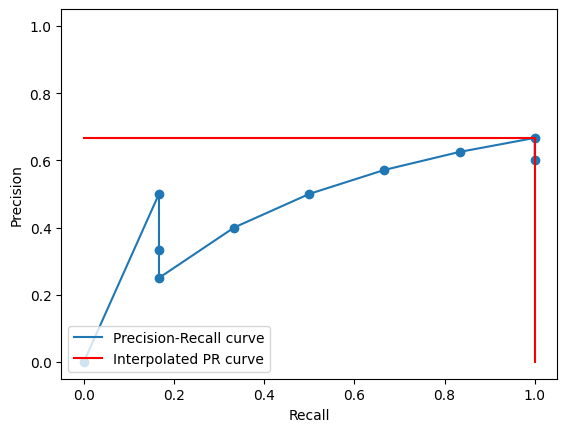

	Query 2


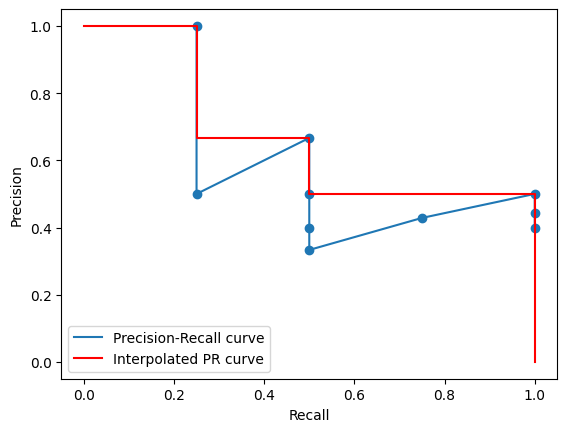

	Query 3


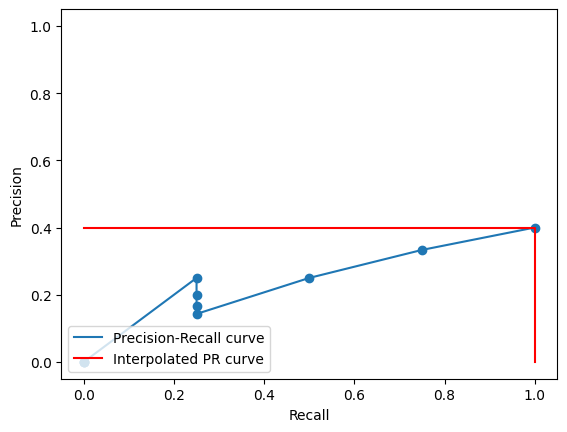

	Query 4


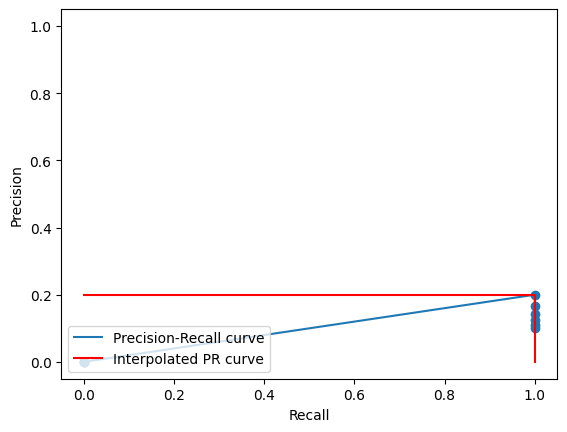

	Query 5


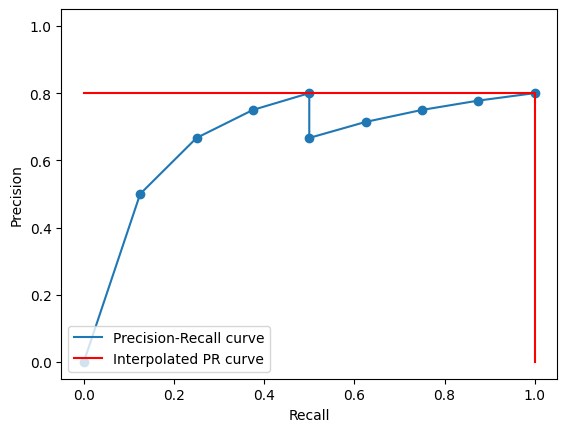

In [17]:
evaluate('prec_rec', Q, R)

# Word embeddings

In [18]:
import gensim.downloader as api

# Load pre-trained word embeddings
word_embeddings_model = api.load("word2vec-google-news-300")

In [19]:
# Function to generate document embeddings
def generate_document_embeddings(documents, word_embeddings_model):
    document_embeddings = []
    for doc in documents:
        # Aggregate word embeddings (e.g., by averaging)
        words = doc.split()
        embeddings = [word_embeddings_model[word] for word in words if word in word_embeddings_model]
        if embeddings:
            doc_embedding = np.mean(embeddings, axis=0)  # Average embeddings
            document_embeddings.append(doc_embedding)
    return np.array(document_embeddings)

# Function to retrieve relevant documents for a query
def retrieve_documents(query_embedding, document_embeddings, documents, document_ids):
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    sorted_documents_indices = similarity_scores.argsort()[::-1]
    sorted_documents = [(document_ids.iloc[i], documents.iloc[i], similarity_scores[i]) for i in sorted_documents_indices]
    return sorted_documents